# User Authentication Based on Mouse Characteristics #

## Load Packages ##

In [1]:
import pandas as pd
import numpy as np

import os
import pickle
from IPython.display import Image

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
script_dir = '/home/lee/Documents/GitHubScripts/balabit-mouse-dynamics-challenge/'

## Construct Features ##

### Remove Out-of-bound Records ###

Coordinates (65535, 65535) mean that the mouse moves out of the remote desktop client; I remove these records as if they never had happened. I have considered the possibility of building features based on whether the mouse has left the client, but I find such events too rare to be indicative. 

In [3]:
def remove_outlier(df):
    df = df[(df['x'] < 65535) & (df['y'] < 65535)].copy()
    df.reset_index(drop=True, inplace=True)

    return df.copy()

### Fill in Coordinates ###

During mouse scrolling, coordinates are not captured. Assign the previous coordinates to the scrolling records. 

In [4]:
def fill_in_scroll(df):
    df.loc[df['button'] == "Scroll", ['x', 'y']] = np.nan
    df['x'].fillna(method='ffill', inplace=True)
    df['y'].fillna(method='ffill', inplace=True)
    
    return df.copy()

### Define Movement Angle ###

The movement angle from mouse position $p_{1}$ to $p_{3}$ is $\gamma$ in the below figure. I do not intend to include the direction of the movement in my feature construction, so $\gamma$ is the absolute value of the difference between $\alpha$ and $\beta$ (both $\alpha$ and $\beta$ are vectors). 

Image source: 
Bailing Wang, Hongri Liu, Kaixin Wang, Guodong Xin, A User Authentication and Identification Model Based on Mouse Dynamics, Proceedings of the 6th International Conference on Information Engineering, August 17-18, 2017, Dalian Liaoning, China \[doi>10.1145/3078564.3078581\]

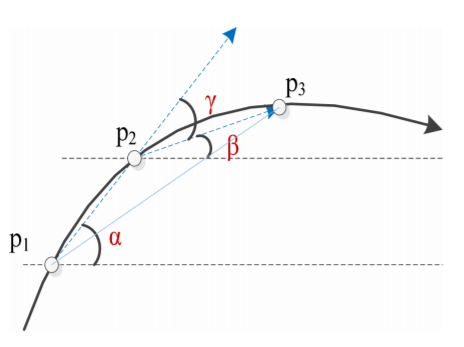

In [5]:
Image(filename = script_dir + 'movement_angle.png')

### Calculate Changes ###

Now for every mouse movement record, calculate changes from the previous record. 

In [6]:
def change_from_prev_rec(df):
    # distance from the last position
    df['distance_from_previous'] = np.sqrt((df['x'].diff())**2 + (df['y'].diff())**2)
    
    # elaspsed time from the previous movement
    df['elapsed_time_from_previous'] = df['client timestamp'].diff()
    
    # angle of the current position, this is the alpha in the figure
    df['angle'] = np.arctan2(df['y'], df['x']) * 180 / np.pi
    df['angle_movement'] = df['angle'].diff()
    # movement angle, this is gamma #
    df['angle_movement_abs'] = abs(df['angle_movement']) 
    
    return df.copy()

### Define Mouse Actions ###

Definition of a mouse action is from one click/scroll to another:
* a complete drag, that starts with a button pressed and ends with the button released with dragging in between
* move + scroll, that includes all the moves leading to a scroll and ends with the end of scrolling
* move + left single click
* move + right single click
* move + double click, where a double click is defined as two consecutive single clicks of the same button within 5 seconds of each other (5s is the maximum double-click interval for MS Windows)
* if there is a break in time longer than 5 seconds between two consecutive "move" records, the first one ends a mouse action and the second one starts a new mouse action.

In [7]:
def classify_categ(df):
    # first, define the action category of each record 
    
    # initialize
    df['categ'] = np.nan
    
    # double click: press -> release -> press -> release, same button
    df.loc[(df['state'] == 'Pressed') & (df.shift(-1)['state'] == 'Released') \
           & (df.shift(-2)['state'] == 'Pressed') \
           & (df.shift(-3)['state'] == 'Released') \
           & (df.shift(-1)['button'] == df.shift(-2)['button']) \
           & (df.shift(-2)['elapsed_time_from_previous'] <= 5) \
           , 'categ'] = 'double_click'
    # After this step, only the ith record is labeled as a double-click. Fill in the other 3. 

    i = 0
    while i <= len(df.index)-4:
        if df.iloc[i]['categ'] == 'double_click':
            df.loc[i+1, 'categ'] = 'double_click'
            df.loc[i+2, 'categ'] = 'double_click'
            df.loc[i+3, 'categ'] = 'double_click'
            i += 4
        else:
            i += 1
    del i 
    # end of double-click
    
    # single click: 
    # 1 only one press-release pair, 
    # 2 previous and following actions are not press-release
    df.loc[(df['state'] == 'Pressed') & (df.shift(-1)['state'] == 'Released') \
           & (df['categ'].isna() == True) & (df['button'] == 'Left')
           , 'categ'] = 'left_click'

    df.loc[(df['state'] == 'Pressed') & (df.shift(-1)['state'] == 'Released') \
           & (df['categ'].isna() == True) & (df['button'] == 'Right')
           , 'categ'] = 'right_click'
    # end of single-click
    
    # drag: press -> drag -> release
    df.loc[((df['state'] == 'Pressed') & (df.shift(-1)['state'] == 'Drag')) \
           | (df['state'] == 'Drag') \
           | ((df['state'] == 'Released') & (df.shift()['state'] == 'Drag')), 'categ'] = 'drag'
    
    # move
    df.loc[(df['state'] == 'Move'), 'categ'] = 'move'
    
    # scroll
    df.loc[(df['state'].isin(['Down', 'Up'])), 'categ'] = 'scroll'
    # end of scroll
    
    df['categ'].fillna(method='ffill', inplace=True)

    # add an empty row at the very end of the dataframe, to help handle the actual last row
    filllastrow = pd.DataFrame(columns = df.columns)
    filllastrow.loc[0, 'categ'] = 'move'
    df = pd.concat([df, filllastrow])

    # Each mouse action as defined above will have an ID for later aggregation, starting from 1. 
    df['action_cnt'] = 0
    action_cnt = 0
    categ_current = np.nan

    # This `for` loop starts from the last but one row of the dataframe and moves backwards.
    # 5 seconds no mouse movement -> considered a break in time, start new action.
    
    # 1. ith record is not move, (i+1)th record is not the same as ith -> new action
    # 2. ith is not drag, (i+1)th is drag -> new action
    # 3. ith record is move, (i+1)th record is move, elapsed time longer than 5s -> new action
    # 4. ith record is scroll, (i+1)th record is scroll, elapsed time longer than 5s -> new action
    for i in range(len(df.index)-2, -1, -1):
        if i == len(df.index)-2:
            categ_current = df.iloc[i]['categ']
            
        if ((df.iloc[i]['categ'] != df.iloc[i+1]['categ']) 
             & (df.iloc[i]['categ'] != 'move')) \
            | ((df.iloc[i]['categ'] != 'drag') \
             & (df.iloc[i+1]['categ'] == 'drag')) \
            | ((df.iloc[i+1]['elapsed_time_from_previous'] > 5) \
             & (df.iloc[i]['categ'] == 'move') \
             & (df.iloc[i+1]['categ'] == 'move')) \
            | ((df.iloc[i+1]['elapsed_time_from_previous'] > 5) \
             & (df.iloc[i]['categ'] == 'scroll') \
             & (df.iloc[i+1]['categ'] == 'scroll')):
            action_cnt -= 1
            categ_current = df.iloc[i]['categ']
            df.loc[i, 'action_cnt'] = action_cnt
            df.loc[i, 'categ_agg'] = categ_current
        else:
            df.loc[i, 'action_cnt'] = action_cnt
            df.loc[i, 'categ_agg'] = categ_current

    # reverse the action IDs
    df['action_cnt'] = df['action_cnt'] - action_cnt

    # remove the last empty row we added
    df = df.iloc[:-1]

    del action_cnt, filllastrow, categ_current
    
    return df.copy()

Prepare for the aggregation step. 

In [8]:
def change_within_action(df):
    # copy the changes to new columns
    df['distance_within_action'] = df['distance_from_previous'].copy()
    df['elapsed_time_within_action'] = df['elapsed_time_from_previous'].copy()
    df['angle_movement_within_action'] = df['angle_movement'].copy()
    df['angle_movement_abs_within_action'] = df['angle_movement_abs'].copy()

    # at the beginning of each action, reset the numbers
    for i in range(1, len(df.index)):
        if df.iloc[i]['action_cnt'] != df.iloc[i-1]['action_cnt']:
            df.loc[i, 'distance_within_action'] = 0
            df.loc[i, 'elapsed_time_within_action'] = 0
            df.loc[i, 'angle_movement_within_action'] = 0
            df.loc[i, 'angle_movement_abs_within_action'] = 0
        else:
            continue

    return df.copy()

In [9]:
# helper
def distance_over_time(distance, time):
    try:
        result = distance / time
    except ZeroDivisionError:
        result = 0
    return result

Now aggregate everything that happens within an action. 

In [10]:
def calc_aggregation(df):
    
    iter_over_df_index = len(df.index)
   
    # Distance covered in pixels, this is the distance the mouse actually has traveled. 
    straight_line_distance = pd.DataFrame(index = df['action_cnt'].unique(), \
                                          columns=['start_t', 'start_x', 'start_y', 'end_t', \
                                                   'end_x', 'end_y'])

    # iter_over_df_index = len(df.index)

    i = 0

    while i <= iter_over_df_index - 1:
        current_loc = 0
        
        if i <= iter_over_df_index - 2:
            if (i == 0) | ((df.iloc[i]['action_cnt'] != df.iloc[i-1]['action_cnt']) \
                           & (df.iloc[i]['action_cnt'] == df.iloc[i+1]['action_cnt'])):
                it = df.iloc[i]['client timestamp'] # starting time
                ix = df.iloc[i]['x'] # initial mouse location x, for this action
                iy = df.iloc[i]['y'] # initial mouse location y, for this action

                j = i + 1
                while j <= iter_over_df_index - 2: 
                    if (df.iloc[j]['action_cnt'] == df.iloc[j-1]['action_cnt']) \
                    & (df.iloc[j]['action_cnt'] != df.iloc[j+1]['action_cnt']):
                        fx = df.iloc[j]['x'] # final mouse location x, for this action
                        fy = df.iloc[j]['y'] # final mouse location y, for this action
                        ft = df.iloc[j]['client timestamp']
                        current_loc = j
                        break
                    else:
                        fx = np.nan
                        fy = np.nan
                        ft = np.nan
                    j += 1
                if j == iter_over_df_index - 1:
                    fx = df.iloc[j]['x'] # final mouse location x, for the very last action
                    fy = df.iloc[j]['y'] # final mouse location y, for the very last action
                    ft = df.iloc[j]['client timestamp']
                    current_loc = j

            elif (i != 0 & df.iloc[i]['action_cnt'] != df.iloc[i-1]['action_cnt'] \
                             & df.iloc[i]['action_cnt'] != df.iloc[i+1]['action_cnt']):
                it = df.iloc[i]['client timestamp'] # starting time
                ix = df.iloc[i]['x'] # initial mouse location x, for this action
                iy = df.iloc[i]['y'] # initial mouse location y, for this action
                ft = df.iloc[i]['client timestamp'] # starting time
                fx = df.iloc[i]['x'] # initial mouse location x, for this action
                fy = df.iloc[i]['y'] # initial mouse location y, for this action
        elif (i == iter_over_df_index - 1) & (df.iloc[i]['action_cnt'] != df.iloc[i-1]['action_cnt']):
            it = df.iloc[i]['client timestamp'] # starting time
            ix = df.iloc[i]['x'] # initial mouse location x, for this action
            iy = df.iloc[i]['y'] # initial mouse location y, for this action
            fx = df.iloc[i]['x'] # final mouse location x, for the very last action
            fy = df.iloc[i]['y'] # final mouse location y, for the very last action
            ft = df.iloc[i]['client timestamp']


            
        straight_line_distance.loc[df.iloc[i]['action_cnt'], 'start_t'] = it
        straight_line_distance.loc[df.iloc[i]['action_cnt'], 'start_x'] = ix
        straight_line_distance.loc[df.iloc[i]['action_cnt'], 'start_y'] = iy
        straight_line_distance.loc[df.iloc[i]['action_cnt'], 'end_t'] = ft
        straight_line_distance.loc[df.iloc[i]['action_cnt'], 'end_x'] = fx
        straight_line_distance.loc[df.iloc[i]['action_cnt'], 'end_y'] = fy

        if current_loc != 0:
            i = current_loc + 1
        else:
            i += 1

    
    df['single_speed'] = df.apply(lambda row: distance_over_time(row['distance_from_previous'], \
                                                                 row['elapsed_time_from_previous']), \
                                                                 axis=1)
    
    
    
    straight_line_distance['shortest_path'] = straight_line_distance.apply(lambda row: \
                                                np.sqrt((row['end_x']-row['start_x'])**2 \
                                                      + (row['end_y']\
                                                       -row['start_y'])**2), axis=1)

    count_move = df.groupby('action_cnt')['action_cnt'].agg('count')
    count_move.rename('count_move', inplace=True)

    distance = df.groupby('action_cnt')['distance_within_action'].agg('sum')
#     elapsed_time = df.groupby('action_cnt')['elapsed_time_within_action'].agg('sum')
    cumulative_angle = df.groupby('action_cnt')['angle_movement_abs_within_action'].agg('sum')
    
    max_speed = df.groupby('action_cnt')['single_speed'].agg('max')
    
    # for each unique value in one column, get unique values in another column
    # then fill the move-only rows
    # mouse_action = df['categ'].groupby(df['action_cnt']).unique().apply(lambda x: list(set(x) - set(['move']))).apply(pd.Series).fillna('move')[0]
    mouse_action = df['categ_agg'].groupby(df['action_cnt']).unique()
    
#     mouse_agg = pd.concat([straight_line_distance, distance, elapsed_time, cumulative_angle, \
#                            mouse_action, max_speed], axis=1)
    mouse_agg = pd.concat([count_move, straight_line_distance, distance, cumulative_angle, mouse_action, max_speed], \
                          axis=1)
    
    
    mouse_agg.rename(columns={0: "action"}, inplace=True)
    
    mouse_agg['total_time'] = mouse_agg['end_t'] - mouse_agg['start_t']
    mouse_agg['total_time'] = pd.to_numeric(mouse_agg['total_time'])
    # some actions appear shorter than the RDP can record, assign the smallest interval the RDP can record 
    mouse_agg.loc[mouse_agg['total_time'] == 0, 'total_time'] = 0.001 
    mouse_agg['avg_angular_speed'] = mouse_agg['angle_movement_abs_within_action'] / mouse_agg['total_time']
    mouse_agg['avg_speed'] = mouse_agg['distance_within_action'] / mouse_agg['total_time']
    mouse_agg['efficiency'] = mouse_agg['shortest_path'] / mouse_agg['distance_within_action']
    mouse_agg['curvature'] = mouse_agg['angle_movement_abs_within_action'] / mouse_agg['distance_within_action']
    
    mouse_agg['categ_agg'] = mouse_agg['categ_agg'].apply(lambda x: x[0])

    mouse_agg['efficiency'].fillna(0, inplace=True)
    mouse_agg['curvature'].fillna(0, inplace=True)
    mouse_agg['avg_angular_speed'].fillna(0, inplace=True)
    mouse_agg['avg_speed'].fillna(0, inplace=True)
    
    mouse_agg.reset_index(inplace=True)
       
    mouse_agg.rename(columns={'distance_within_action': 'distance',
                             'total_time': 'total_time_action',
                             'angle_movement_abs_within_action': 'sum_angles',
                             'single_speed': 'max_speed'}, inplace=True)
    
    mouse_agg = mouse_agg[mouse_agg['count_move'] >= 3].copy()
    mouse_agg = mouse_agg[mouse_agg['shortest_path'] <= 2203].copy()
    
    
    mouse_agg.drop(columns=['action_cnt', 'start_t', 'start_x', 'start_y', 'end_t', \
                            'end_x', 'end_y'], inplace=True)
    return mouse_agg

Finally we have these features for each action:
average speed, maximum speed, travel distance, shortest path, efficiency (ratio of shortest path and distance traveled), total time of mouse action, sum of angles in paths, curvature (ration of the sum of angles and distance traveled), average angular speed. 

In [11]:
# put all the sessions together
def all_feature_extraction(file_paths):
    df_list = []

    for file_path in file_paths:

        df = pd.read_csv(file_path)
        df['user'] = file_path.split(os.path.sep)[-2]
        df['session'] = file_path.split(os.path.sep)[-1]

        df.drop_duplicates(inplace=True)

        df.reset_index(drop=True, inplace=True)

        df_remove_outlier = remove_outlier(df)
        df_fill_in_scroll = fill_in_scroll(df_remove_outlier)
        df_change_from_prev_rec = change_from_prev_rec(df_fill_in_scroll)
        df_classify_categ = classify_categ(df_change_from_prev_rec)
        df_change_within_action = change_within_action(df_classify_categ)
        df_mouse_agg = calc_aggregation(df_change_within_action)

        df_mouse_agg['user'] = file_path.split(os.path.sep)[-2]
        df_mouse_agg['session'] = file_path.split(os.path.sep)[-1]

        df_list.append(df_mouse_agg)

        del df, df_remove_outlier, df_fill_in_scroll, df_change_from_prev_rec, df_classify_categ, \
        df_change_within_action, df_mouse_agg
        
    return df_list

## Load Data ##

In [ ]:
data_dir = '/home/lee/Documents/DatasetsForGitHub/balabit_mouse_dynamics_challenge/'

file_paths = []
for root, dirs, files in os.walk(data_dir + "training_files/"):
    for file in files:
        file_paths.append(os.path.join(root, file))

### Apply Feature Construction Functions ###

In [12]:
df_train_lst = all_feature_extraction(file_paths)

df_train = pd.concat(df_train_lst, axis=0, ignore_index=True)

del df_train_lst

# pickle training data
with open(data_dir+'all_training_aggregation.pickle', 'wb') as handle:
    pickle.dump(df_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
del file_paths

In [13]:
file_paths = []
for root, dirs, files in os.walk(data_dir + "test_files/"):
    for file in files:
        file_paths.append(os.path.join(root, file))
        
df_test_lst = all_feature_extraction(file_paths)

df_test = pd.concat(df_test_lst, axis=0, ignore_index=True)

del df_test_lst

# pickle test data
with open(data_dir+'all_testing_aggregation.pickle', 'wb') as handle:
    pickle.dump(df_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
del file_paths